In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

In [2]:
#Read dataset
df = pd.read_csv("/Users/queene/Desktop/DM/MeSHApp/pubmed-diabetesme-set.csv", sep=';', header=0)
df = df[pd.isna(df['PMID'])==False]
df = df[pd.isna(df['TI'])==False]
df = df[pd.isna(df['AB'])==False]
df = df[pd.isna(df['MH'])==False]

In [3]:
#Preview the file 
df.head(5)

,PMID,DP,TI,AB,MH
0,27080137,2016 Jun,Diabetes mellitus and its complications in India.,India is one of the epicentres of the global d...,"Developing Countries, Diabetes Complications/*..."
1,9803200,1998 Oct 15,Diagnosis and classification of diabetes melli...,New recommendations for the classification and...,"Blood Glucose/metabolism, Diabetes Mellitus/bl..."
2,15137354,2004 Apr-Jun,Pathophysiology of diabetes mellitus.,As we learn more about the pathophysiology of ...,"Diabetes Mellitus, Type 1/complications/*metab..."
3,8481881,1993 Apr,Diabetes mellitus.,Diabetes mellitus occurs commonly in the older...,"Adult, Aged, Aging, Diabetes Complications, Di..."
4,23185815,2012 Jan 18,[Diabetes mellitus].,The globalization became the topic the most of...,"Biomarkers/blood. Chronic Disease, Diabetes Me..."


In [4]:
#FEATURE 2: Article Ranking using Cosine Similarity 

#TFIDF Calculation
text_abstract = df['AB']
vector = TfidfVectorizer(max_df=0.3,               # Drop words occuring more than X percent of articles 
                             min_df=8,             # Only use words appear at least X times
                             stop_words='english', # Remove stop words
                             lowercase=True,       # Convert to lowercase 
                             use_idf=True,         # Use idf
                             norm=u'l2',           # Normalization
                             smooth_idf=True       # Prevents divide-by-zero errors
                            )

tfidf = vector.fit_transform(text_abstract)

In [5]:
#Search Function 
# Request function : search the top_n articles from a request ( request = string)
def search(tfidf_matrix,model,request, top_n = 5):
    request_transform = model.transform([request])
    similarity = np.dot(request_transform,np.transpose(tfidf_matrix))
    x = np.array(similarity.toarray()[0])
    indices=np.argsort(x)[-5:][::-1]
    return indices

# Find similar : get the top_n articles similar to an article 
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]    

# Print the result
def print_result(request_content,indices,X):
    print('\nSearch : ' + request_content)
    print('\nBest Results :')
    for i in indices:
        print('Index = {0:5d} - Title = {1}'.format(i,df['TI'].loc[i]))
        

In [6]:
#Similar articles 
index = 1
result = find_similar(tfidf, index, top_n = 5)
print_result('04 - Abstract = Diabetes mellitus occurs commonly in the older patient and is frequently undiagnosed. In many cases, the initial manifestations of diabetes mellitus are lower extremity complications with which this disease is known to be associated. Unfortunately, these complications are similar to other age-related degenerative processes; therefore, vigilance for the detection of undiagnosed diabetes mellitus is essential in the evaluation and treatment of lower extremity pathologic conditions.',result,df)



Search : 04 - Abstract = Diabetes mellitus occurs commonly in the older patient and is frequently undiagnosed. In many cases, the initial manifestations of diabetes mellitus are lower extremity complications with which this disease is known to be associated. Unfortunately, these complications are similar to other age-related degenerative processes; therefore, vigilance for the detection of undiagnosed diabetes mellitus is essential in the evaluation and treatment of lower extremity pathologic conditions.

Best Results :
Index =    26 - Title = [Post-transplantational diabetes mellitus].
Index =    49 - Title = [Diabetes mellitus: from clinical knowledge to public health concern].
Index =    36 - Title = Diabetes: an overview.
Index =    45 - Title = [Diabetes mellitus: current classification based on cause and sharpened blood
Index =    38 - Title = Personalized medicine in diabetes.


In [7]:
#FEATURE 1: MeSH Recommendation 
import yake

kw_extractor = yake.KeywordExtractor()

text = "Diabetes mellitus occurs commonly in the older patient and is frequently undiagnosed. In many cases, the initial manifestations of diabetes mellitus are lower extremity complications with which this disease is known to be associated. Unfortunately, these complications are similar to other age-related degenerative processes; therefore, vigilance for the detection of undiagnosed diabetes mellitus is essential in the evaluation and treatment of lower extremity pathologic conditions."

#Specify Parameters
language = "en"
max_ngram_size = 2
deduplication_threshold = 0.9
deduplication_algo = 'seqm'
numOfKeywords = 10

#Default Parameters
custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
keywords = custom_kw_extractor.extract_keywords(text)

for kw in keywords:
    print(kw)


('occurs commonly', 0.040895255811390585)
('older patient', 0.040895255811390585)
('Diabetes mellitus', 0.04276930896710812)
('mellitus occurs', 0.07162925524254193)
('frequently undiagnosed', 0.0938478931828417)
('lower extremity', 0.10835422568641724)
('Diabetes', 0.1124065632212028)
('mellitus', 0.1124065632212028)
('undiagnosed diabetes', 0.17091166257062068)
('occurs', 0.19821337210587486)


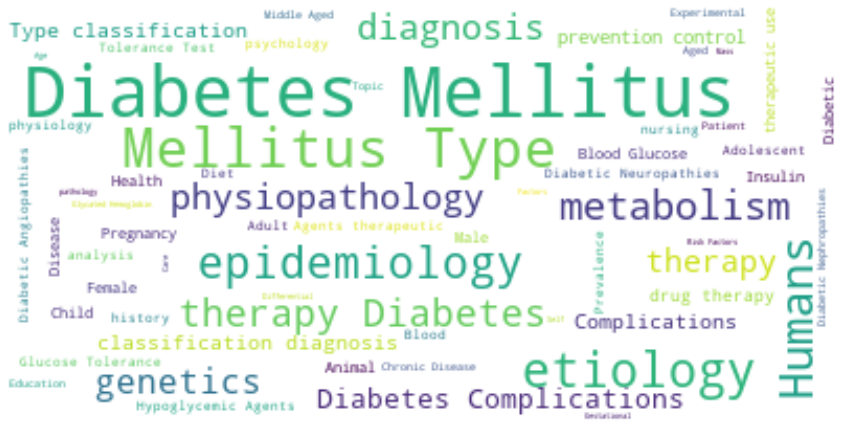

In [8]:
#FEATURE 3: Visulization of Terms 
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

text = " ".join(i for i in df['MH'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()             
                   

In [9]:
"""
from sklearn.model_selection import train_test_split

# Logistic Regression 
def one_v_all_learning(records):
    X = []
    y = []
    for d in records: 
        X.append(d[0])
        y.append(d[1])
        
    X = np.array(X)
    y = np.array(y)
    
    # Sampling dataset
    vectorizer_X = TfidfVectorizer(analyzer='word', min_df=0.0, max_df=1.0,
                                  strip_accents=None, encoding='utf-8',
                                  preprocessor=None,
                                  token_pattern=r"(?u)\S\S+",
                                  max_features=1000)
    
    # 80/20 split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=0)
    
    # TF-IDF matrices
    X_tfidf_train = vectorizer_X.fit_transform(X_train)
    X_tfidf_test = vectorizer_X.transform(X_test)
    
    #dimensionality reduction dengan PCA
    pca = PCA(n_components=0.95)
    X_tfidf_train = pca.fit_transform(X_tfidf_train.todense())
    X_tfidf_test = pca.transform(X_tfidf_test.todense())
    
    mh_list = []
    for d in records: 
        mh_list += d[1]
    values, counts = np.unique(mh_list, return_counts=True)
    ind = (-counts),argsort()[:10]
    top_tags = values[ind]
    print(top_tags)
    reports = {}
    for i in range(len(top_tags)):
        y_train_temp = [l if top_tags[i] in row else 0 for row in y_train]
        y_test_temp = [l if top_tags[i] in row else 0 for row in y_test]
        clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=1)
        clf.fit(X_tfidf_train, y_train_temp)
        preds = clf.predict(X_tfidf_test)
        print("Classification Class Result {}".format(top_tags[i]))
        print(classification_report(y_test_temp, preds))
        reports[top_tags[i]] = classification_report(y_test_temp, preds, output_dict=True)
        return reports
    
    logreg_report_combined = one_v_all_learning(records_combined)
    report_combined = one_v_all_learning(records_combined)
    
    print(reports)
"""

'\nfrom sklearn.model_selection import train_test_split\n\n# Logistic Regression \ndef one_v_all_learning(records):\n    X = []\n    y = []\n    for d in records: \n        X.append(d[0])\n        y.append(d[1])\n        \n    X = np.array(X)\n    y = np.array(y)\n    \n    # Sampling dataset\n    vectorizer_X = TfidfVectorizer(analyzer=\'word\', min_df=0.0, max_df=1.0,\n                                  strip_accents=None, encoding=\'utf-8\',\n                                  preprocessor=None,\n                                  token_pattern=r"(?u)\\S\\S+",\n                                  max_features=1000)\n    \n    # 80/20 split\n    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=0)\n    \n    # TF-IDF matrices\n    X_tfidf_train = vectorizer_X.fit_transform(X_train)\n    X_tfidf_test = vectorizer_X.transform(X_test)\n    \n    #dimensionality reduction dengan PCA\n    pca = PCA(n_components=0.95)\n    X_tfidf_train = pca.